# Assembling our NB CRP 

In [430]:
import scanpy as sc

adata = sc.read_h5ad("/Users/jameshaberberger/GitHub/chinese-restaurant-process/data/adata.h5ad")
adata.X = adata.X.todense()

counts = torch.tensor(adata.X)
counts = counts[counts.sum(axis=1) > 300][::10]
size_factors = (counts.sum(axis=1) / counts.sum(axis=1).mean()).log()

/Users/jameshaberberger/GitHub/chinese-restaurant-process/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


### Conjugate-like posterior predictive using a Gamma-Poisson Approximation

$$
x_n \sim \text{Poisson}(\lambda_k)
$$

$$
\lambda_k \sim \text{Gamma}(\alpha_k, \beta_k)
$$

The wonderful thing here is that the sufficient statistics are just derived from taking aggregates of the population, so the posterior predictives are literally just:

$$
\alpha_k^{\text{ post }} = \alpha_0 + \sum x_i
$$

$$
\beta_k^{\text{ post }} = \beta_0 + N_k
$$

Lets do it really manually, to show whats going on.

In [323]:
import torch

import pyro
import pyro.distributions as dist

Our global priors are just the moments (the mean and variance).

In [364]:
alpha_prior = counts.mean(dim=0).pow(2) / counts.var(dim=0)
beta_prior = counts.mean(dim=0) / counts.var(dim=0)

In [365]:
class ChineseRestaurantTable:
    beta_prior_ = None
    alpha_prior_ = None

    def __init__(self, alpha_prior, beta_prior):
        self.set_prior(alpha_prior, beta_prior)
        self.indices = []

    @classmethod
    def set_prior(cls, alpha_prior, beta_prior):
        cls.alpha_prior_ = alpha_prior
        cls.beta_prior_ = beta_prior
    
    def posterior_alpha(self, data, new_index = None):
        if new_index is not None:
            return self.alpha_prior_ + data[self.indices + [new_index]].sum(dim=0)
        else:
            return self.alpha_prior_ + data[self.indices].sum(dim=0)

    def posterior_beta(self, new_index = None):
        if new_index is not None:
            return self.beta_prior_ + (len(self.indices) + 1)
        else:
            return self.beta_prior_ + len(self.indices)
    
    def log_likelihood(self, counts, new_index, size_factors):
        return dist.NegativeBinomial(
            total_count=self.posterior_alpha(counts, new_index=new_index), 
            logits=-torch.log1p(1 / self.posterior_beta(new_index=new_index)) + size_factors[new_index]
        ).log_prob(counts[new_index]).sum()
    
    def add_index(self, index):
        if index not in self.indices:
            self.indices.append(index)
        else:
            raise ValueError(f"Index {index} already exists in the table.")
    
    def remove_index(self, index):
        if index in self.indices:
            self.indices.remove(index)
        else:
            raise ValueError(f"Index {index} does not exist in the table.")
    
    def __len__(self):
        return len(self.indices)

In [419]:
class ChineseRestaurantTable:
    beta_prior_ = None
    alpha_prior_ = None

    def __init__(self, alpha_prior, beta_prior):
        self.set_prior(alpha_prior, beta_prior)
        self.indices = []
        self.age = 0               # number of iterations alive
        self.inactive_steps = 0   # # of times it's under threshold

    @classmethod
    def set_prior(cls, alpha_prior, beta_prior):
        cls.alpha_prior_ = alpha_prior
        cls.beta_prior_ = beta_prior
    
    def posterior_alpha(self, data, new_index = None):
        if new_index is not None:
            return self.alpha_prior_ + data[self.indices + [new_index]].sum(dim=0)
        else:
            return self.alpha_prior_ + data[self.indices].sum(dim=0)

    def posterior_beta(self, new_index = None):
        if new_index is not None:
            return self.beta_prior_ + (len(self.indices) + 1)
        else:
            return self.beta_prior_ + len(self.indices)
    
    def log_likelihood(self, counts, new_index, size_factors):
        return dist.NegativeBinomial(
            total_count=self.posterior_alpha(counts, new_index=new_index), 
            logits=-torch.log1p(1 / self.posterior_beta(new_index=new_index)) + size_factors[new_index]
        ).log_prob(counts[new_index]).sum()
    
    def add_index(self, index):
        if index not in self.indices:
            self.indices.append(index)
        else:
            raise ValueError(f"Index {index} already exists in the table.")
    
    def remove_index(self, index):
        if index in self.indices:
            self.indices.remove(index)
        else:
            raise ValueError(f"Index {index} does not exist in the table.")
    
    def __len__(self):
        return len(self.indices)

    def log_marginal_likelihood(self, data, new_index, size_factors, eps=1e-6):
        α0 = torch.clamp(self.alpha_prior_, min=eps)
        β0 = torch.clamp(self.beta_prior_, min=eps)

        indices = self.indices + [new_index]
        X = data[indices]
        S = size_factors[indices].unsqueeze(1)

        X_adj = X / S
        X_adj = torch.clamp(X_adj, min=eps)  # guard against zeros

        sum_x = X_adj.sum(dim=0)  # (D,)
        n = X_adj.shape[0]

        denom = β0 + n
        safe_denom = torch.clamp(denom, min=eps)
        safe_log_ratio = torch.log(torch.clamp(β0 / safe_denom, min=eps))
        safe_log_inv_denom = torch.log(torch.clamp(1.0 / safe_denom, min=eps))

        lgamma_x_plus_1 = torch.lgamma(X_adj + 1)
        sum_lgamma_x_plus_1 = lgamma_x_plus_1.sum(dim=0)

        log_prob = (
            torch.lgamma(sum_x + α0)
            - sum_lgamma_x_plus_1
            - torch.lgamma(α0)
            + α0 * safe_log_ratio
            + sum_x * safe_log_inv_denom
        )

        return log_prob.sum()



# Marginal Likelihood

In [433]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from IPython.display import clear_output

alpha = 10 / np.log(counts.shape[0])
assignments = [-1] * counts.shape[0]
clusters = dict()

for epoch in range(10):
    for ix in tqdm(range(counts.shape[0])):
        ix = int(ix)  # ensure integer indexing
        k_old = assignments[ix]
        assignments[ix] = -1  # temporarily remove assignment

        # Remove from old cluster
        if k_old != -1:
            clusters[k_old].remove_index(ix)
            if len(clusters[k_old]) == 0:
                del clusters[k_old]

        # Prepare candidate cluster list
        crp_new = ChineseRestaurantTable(alpha_prior, beta_prior)
        labels = list(clusters.keys()) + ["new"]

        log_probs = []

        for k in labels:
            if k == "new":
                log_lik = crp_new.log_marginal_likelihood(
                    counts, new_index=ix, size_factors=size_factors
                )
                log_prior = np.log(alpha)
            else:
                log_lik = clusters[k].log_marginal_likelihood(
                    counts, new_index=ix, size_factors=size_factors
                )
                log_prior = np.log(len(clusters[k]))

            # Normalize likelihood per feature dimension
            log_prob = (log_lik / counts.shape[1]) + log_prior
            log_probs.append(log_prob)

        # Convert to tensor and compute softmax
        log_probs = torch.stack(log_probs)  # shape: (K+1,)
        probs = F.softmax(log_probs, dim=0)

        # Sample new assignment
        k_idx = torch.multinomial(probs, num_samples=1).item()
        k_new = labels[k_idx]

        if k_new == "new":
            k_new = max(clusters.keys(), default=-1) + 1
            clusters[k_new] = crp_new

        assignments[ix] = k_new
        clusters[k_new].add_index(ix)

        # Clean up inactive clusters
        min_members = 10
        max_inactive = 500

        for k, table in list(clusters.items()):
            table.age += 1

            if len(table) < min_members:
                table.inactive_steps += 1
            else:
                table.inactive_steps = 0  # reset if it regains members

            if table.inactive_steps >= max_inactive:
                # Remove the table and reassign its members
                print(f"Deleting inactive table {k}")
                for ix in table.indices:
                    assignments[ix] = -1  # mark as unassigned
                del clusters[k]
        clear_output()



100%|██████████| 1832/1832 [00:26<00:00, 68.69it/s]


<Axes: >

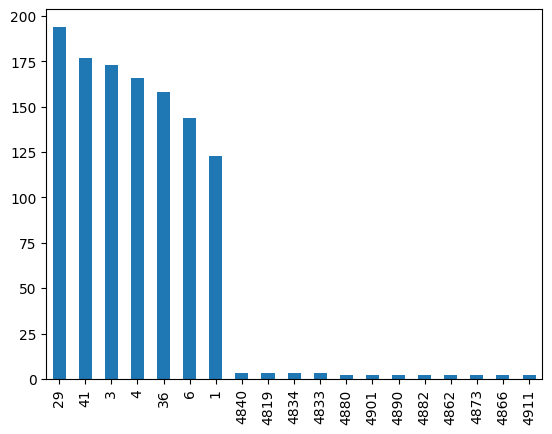

In [434]:
pd.Series(assignments).value_counts().iloc[1:20].plot.bar()